In [1]:
from typing import Dict

from inspect import signature
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn import tree

# Combinatorial Analysis

We are going to compare using all possible feature sets for both molecular weight and siderophore prediction.

I have gone ahead and written a `load_data` function that makes sure all datasets are on the exact same examples. Please see the function documentation for more information on how that is done so we can discuss!

In [2]:
from data_loading import load_mibig_metadata, load_data

meta = load_mibig_metadata()
datasets = load_data(meta)

Using 848 BGCs with both pfam and cath transporters, as well as Gram +/-.
Dataset pfam has 0 examples with all zeros.
Dataset cath has 0 examples with all zeros.
Dataset sbp has 759 examples with all zeros.
Dataset biosynthetic has 115 examples with all zeros.


`datasets` is a dict with keys for each of the major feature types. All of them have the same examples by our filtering choice.

In [3]:
datasets.keys()

dict_keys(['pfam', 'cath', 'sbp', 'biosynthetic'])

# Preprocessing

I have written preprocessing functions that apply to any dataset (or concatenation of datasets). This helps us apply a uniform preprocessing pipeline to any dataset of interest.

Notice how there is a `verbose` option if you want to see some statistics for each preprocessing run.

In [4]:
from prediction_utils import siderophore_preprocess

In [5]:
siderophore_data = {k: siderophore_preprocess(d, meta, verbose=True) for k, d in datasets.items()}

There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218
There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218
There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218
There are 257 examples for siderophore prediction.
Num positives: 39
Num negatives: 218


# Fitting on all subsets

We now need to iterate over all subsets of possible features, fit our model, and compare some results.

To do this, I have written a `fit_all_subsets` function that takes our dict of possible compatible feature sets and loops over all valid combinations. Each combination is concatenated and de-duplicated, split into features and labels, then fed to `fit_classifier`. This returns the classifier, precision, recall, and aupr. We also track the feature names and dataset combinations for each subset.

Notice that we are _also_ tracking Gram type, so the nesting gets a bit annoying.

In [6]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [7]:
from prediction_utils import fit_classifier, create_clf_data

def fit_all_subsets(dataset: Dict[str, pd.DataFrame]):

    precisions = {1: [], 0: []}
    recalls = {1: [], 0: []}
    auprs = {1: [], 0: []}
    trees = {1: [], 0: []}
    names = []
    features = []

    for subset in powerset(dataset.items()):
        clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3)
        if len(subset) == 0:
            continue
        # Subset is of the form ((key, data), (key, data), ...)
        # so we have to slice it.
        keys = [x[0] for x in subset] 
        df = [x[1].set_index('BGC') for x in subset]
        df = pd.concat(df, axis=1)

        # Bookkeeping: make BGC a column and remove duplications
        df = df.reset_index()
        df = df.loc[:, ~df.columns.duplicated()]

        names.append(' + '.join(keys))
        features.append(df.columns.drop(['BGC', 'label', 'Gram']))
        for gram_type, d in df.groupby('Gram'):
            X, y = create_clf_data(d)

            fit_clf, precision, recall, aupr = fit_classifier(X, y, clf)

            precisions[gram_type].append(precision)
            recalls[gram_type].append(recall)
            auprs[gram_type].append(aupr)
            trees[gram_type].append(fit_clf)
            
    return precisions, recalls, auprs, trees, names, features

In [8]:
sid_pr, sid_rec, sid_auprs, sid_trees, names, features = fit_all_subsets(siderophore_data)

# Visualization

We have three tools for visualization, as we discussed earlier today. 

1. Displaying the auPRs in a table.
2. Plotting all PR curves in one plot.
3. Showing the trees.

## Displaying auPR table

This is simplest. We will just generate a table to show results for G+ and G- separately. Notice that it is all in a dataframe `df` so it should be easy to mess with!

In [9]:
from IPython.display import display
def print_aupr(auprs, names):
    x = pd.DataFrame(auprs)
    x['Protein Families'] = names
    x = x.rename(columns={1: 'G+', 0: 'G-'})
    display(x.set_index('Protein Families'))
    
    return x

In [10]:
df = print_aupr(sid_auprs, names)

,G+,G-
Protein Families,,
pfam,0.704433,0.921875
cath,0.815707,0.921875
sbp,0.693386,0.583333
biosynthetic,0.631309,0.705426
pfam + cath,0.815707,0.921875
pfam + sbp,0.741181,0.921875
pfam + biosynthetic,0.692573,0.921875
cath + sbp,0.815707,0.921875
cath + biosynthetic,0.815707,0.921875


## Plot PR Curves

Next, we want to plot the PR curves for all models for the G+ and G- case separately. I am feeding some random cmap I found, but you can replace with whatever cmap catches your eye here:

https://matplotlib.org/tutorials/colors/colormaps.html

In [11]:
def plot_pr_curves(precisions, recalls, names, task, cmap_name):
    cm = plt.get_cmap(cmap_name)

    for gram_type in precisions:
        _recalls = recalls[gram_type]
        _precisions = precisions[gram_type]
        cgen = [cm(1. * i/len(_recalls)) for i in range(len(_recalls))]

        plt.figure(figsize=(12, 12))
        plt.title(f'Performance on {task} for Gram {gram_type}.')
        for color, precision, recall, key in zip(cgen, _precisions, _recalls, names):
            step_kwargs = ({'step': 'post'}
                          if 'step' in signature(plt.fill_between).parameters
                           else {})
            plt.step(recall, precision, alpha=1., color=color,
                     where='post', label=key)

            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
        plt.legend()
        plt.show()

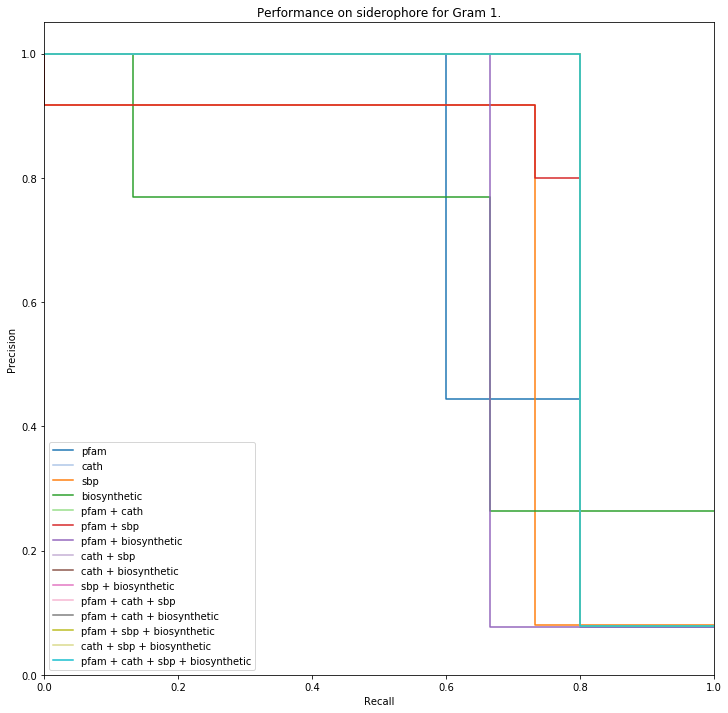

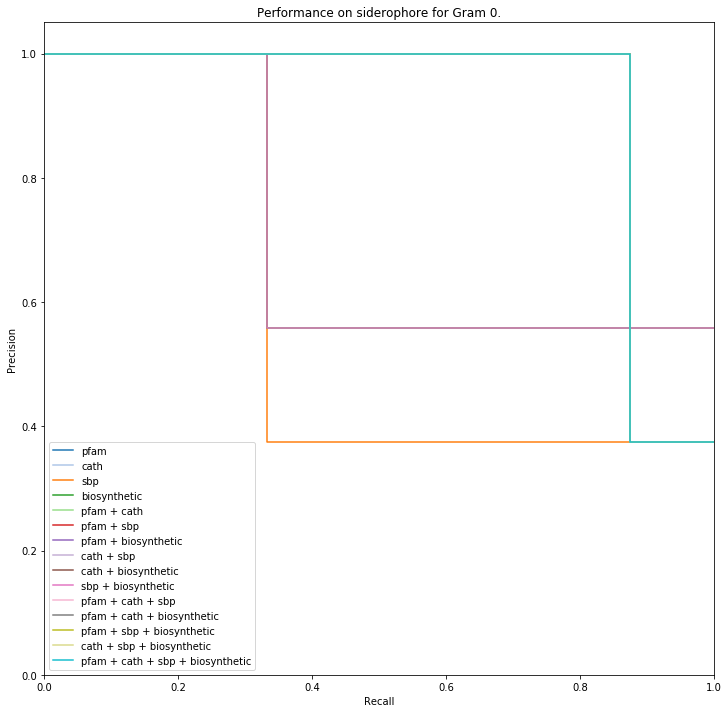

In [12]:
plot_pr_curves(sid_pr, sid_rec, names, 'siderophore', 'tab20')

## Tree Plotting

I am just looping and plotting right now: making `tree.plot_tree` get along with subplots is honestly a pain in the ass. After like 45 minutes I decided it wasn't worth, since we will switch to the fancy plotting stuff you find. Hopefully that works better anyways.

Notice that `trees` has all trees available for both G+ and G- separately, so it should be easy to plug in to other plotting toolkits.

In [13]:
def plot_trees(trees, names, auprs, feature_names, task):
    
    for gram_type, tree_list in trees.items():
        _auprs = auprs[gram_type]
        print(f'Trees for MW, Gram: {gram_type}')    
        for clf, name, aupr, _features in zip(tree_list, names, _auprs, feature_names):
            plt.figure(figsize=(10,10))
            tree.plot_tree(clf, feature_names=_features)
            plt.title(f'task: {task} with Gram {gram_type}\n features: {name}\n aupr: {round(aupr, 3)}')
            plt.show() 
        print('='*100)

Trees for MW, Gram: 1


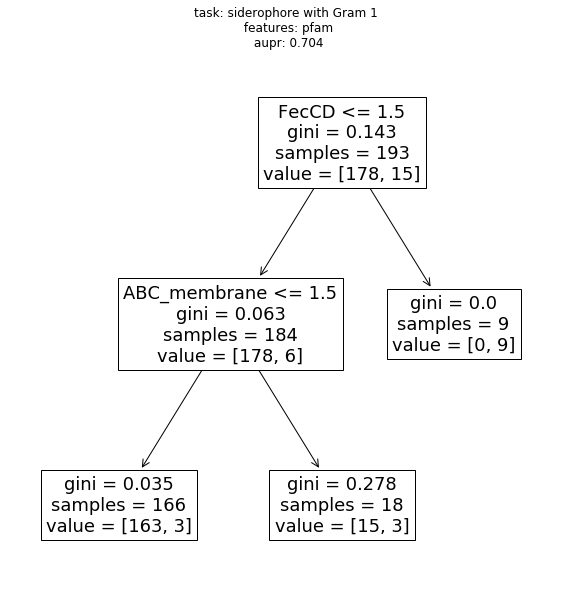

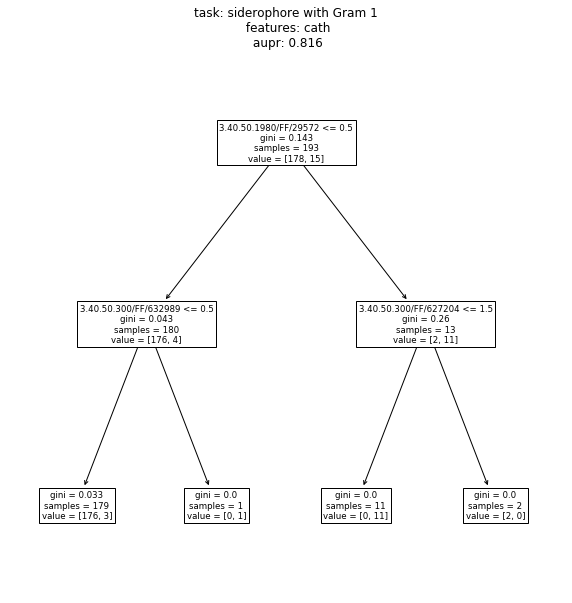

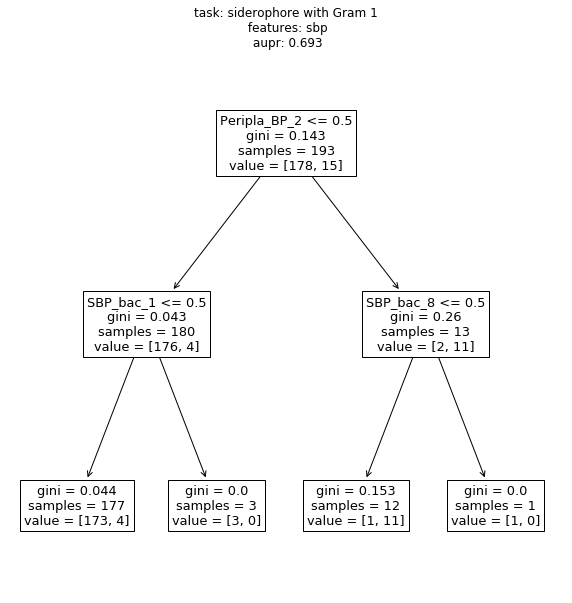

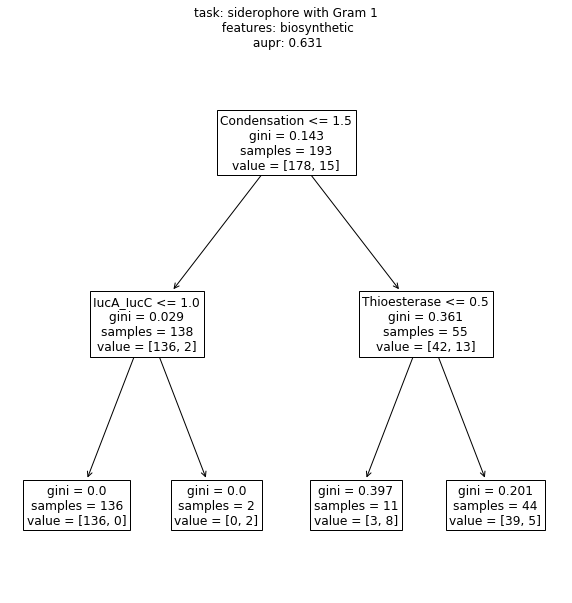

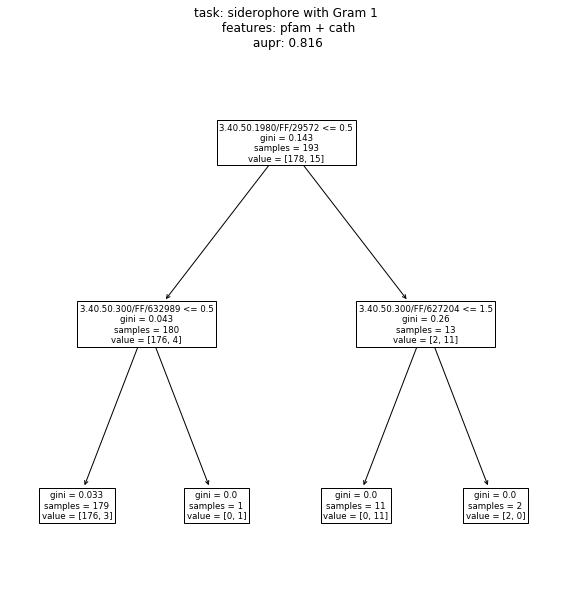

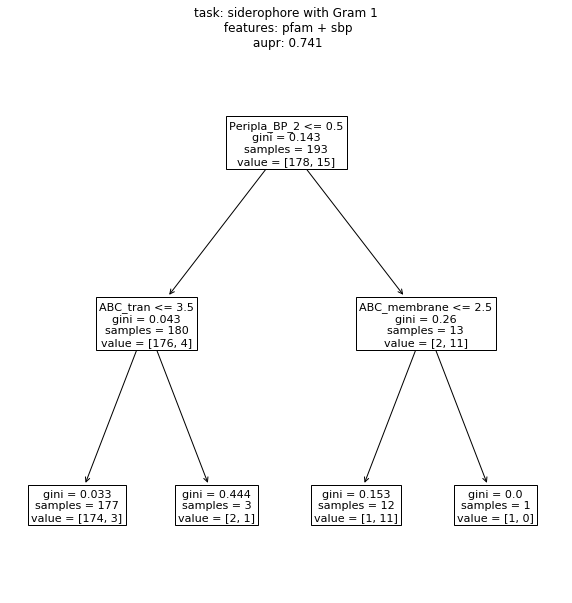

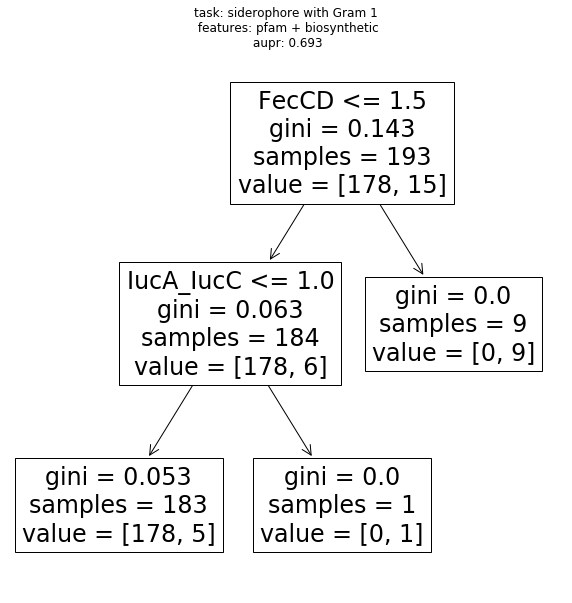

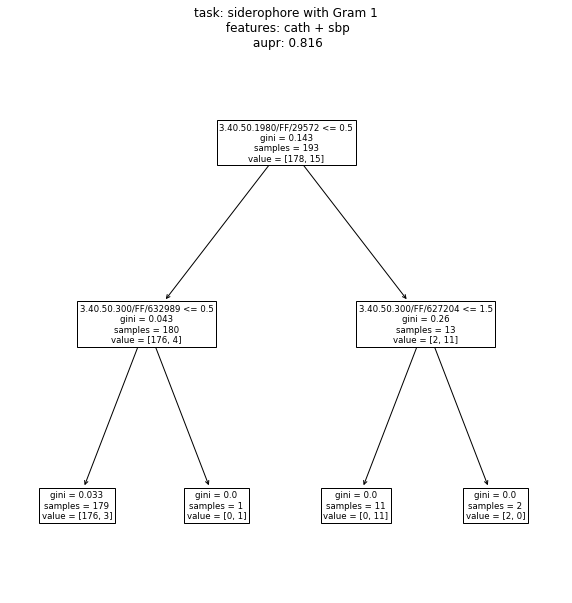

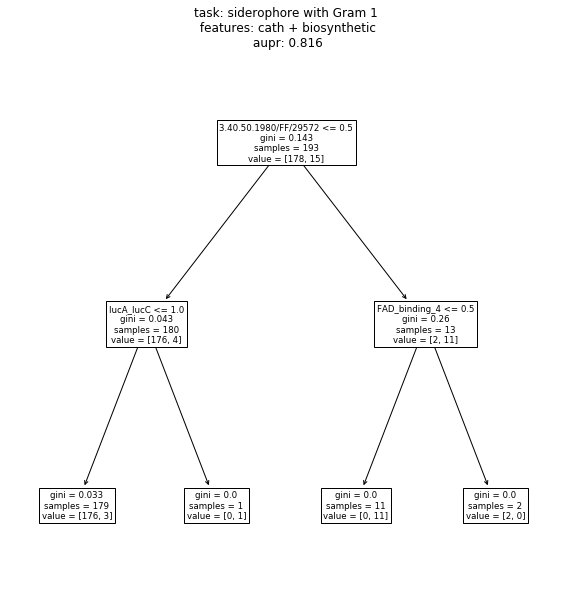

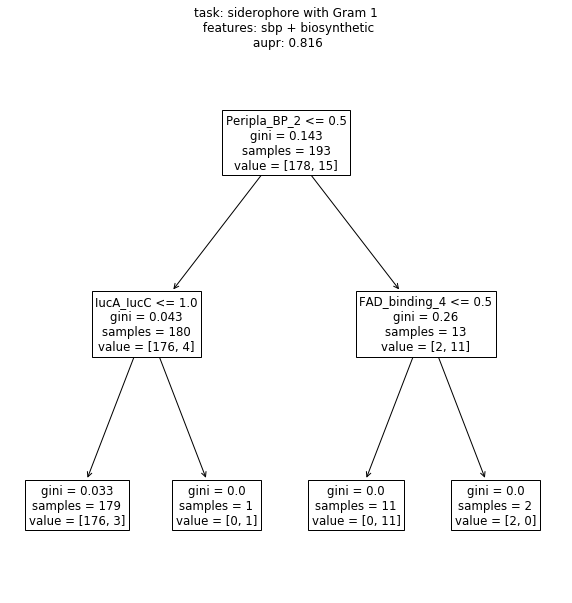

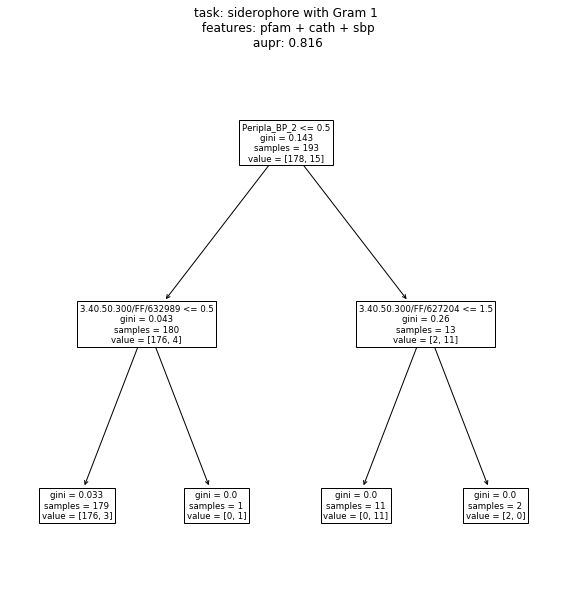

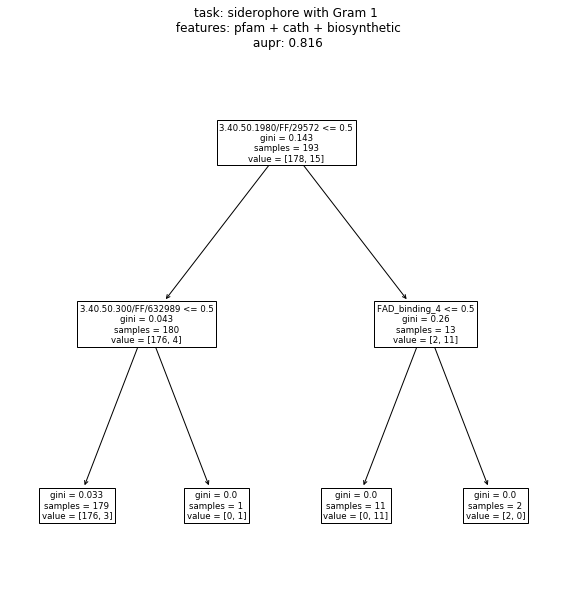

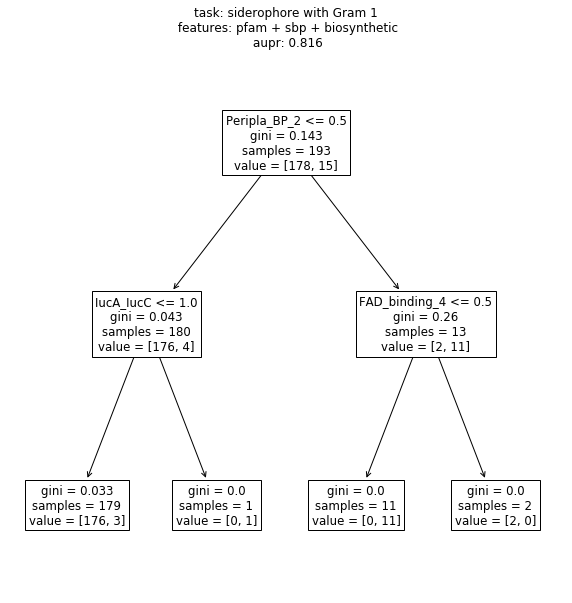

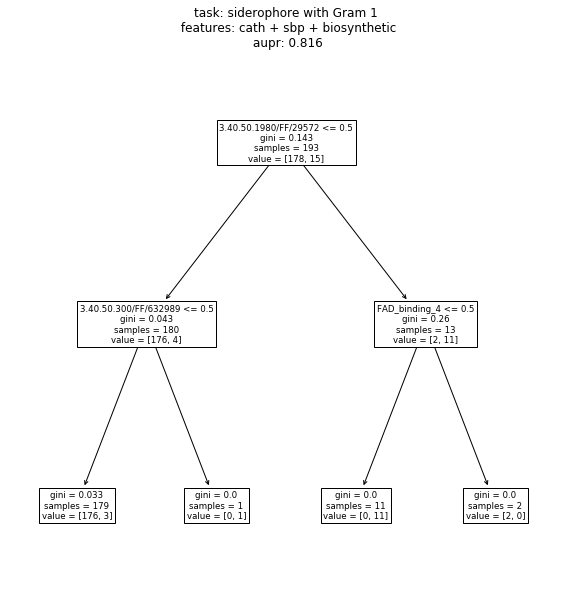

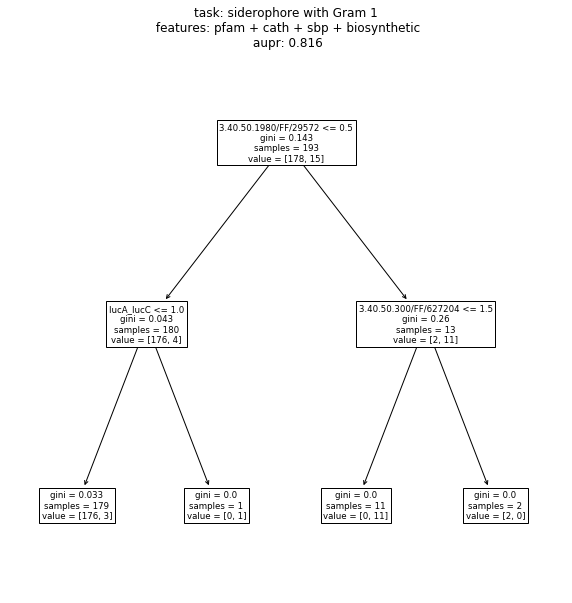

Trees for MW, Gram: 0


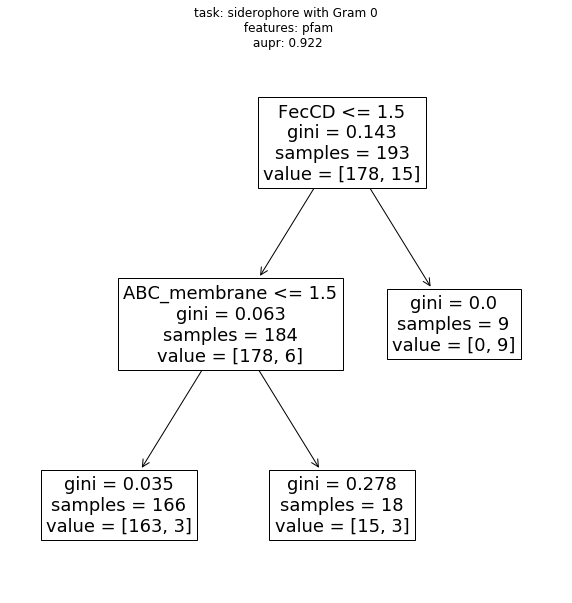

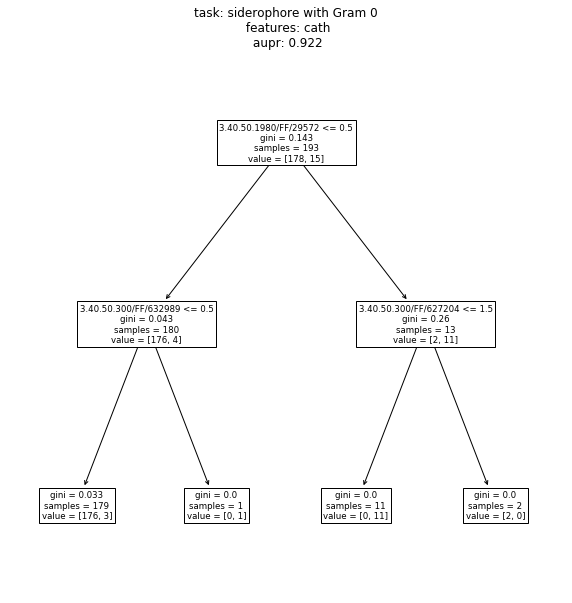

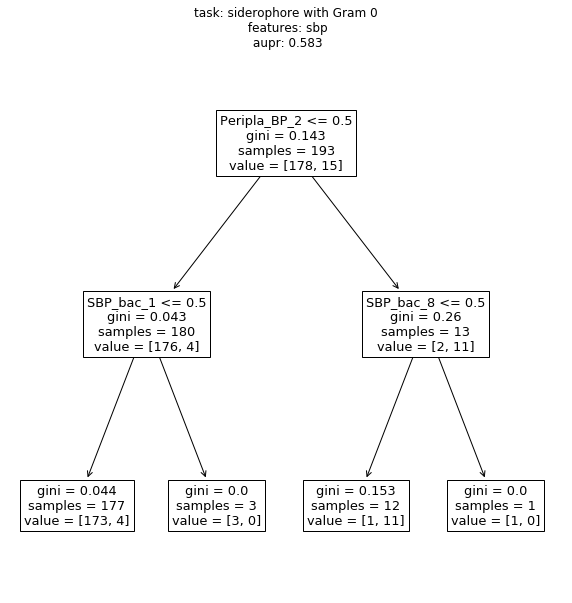

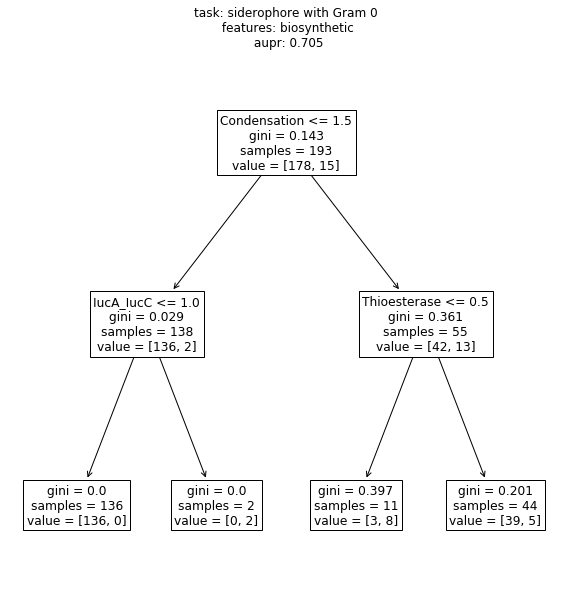

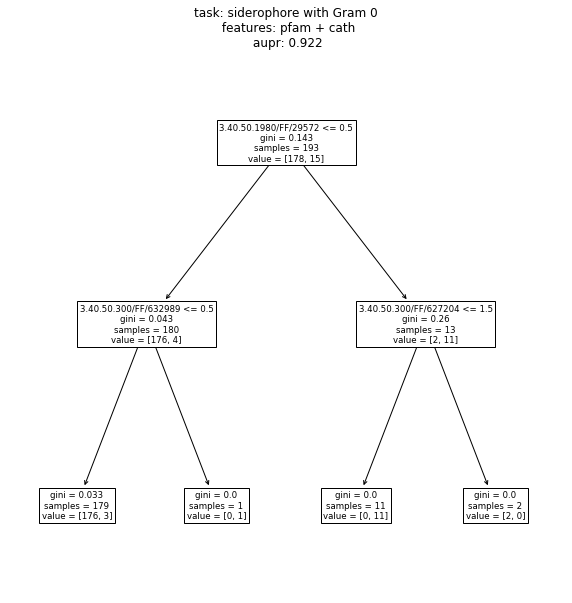

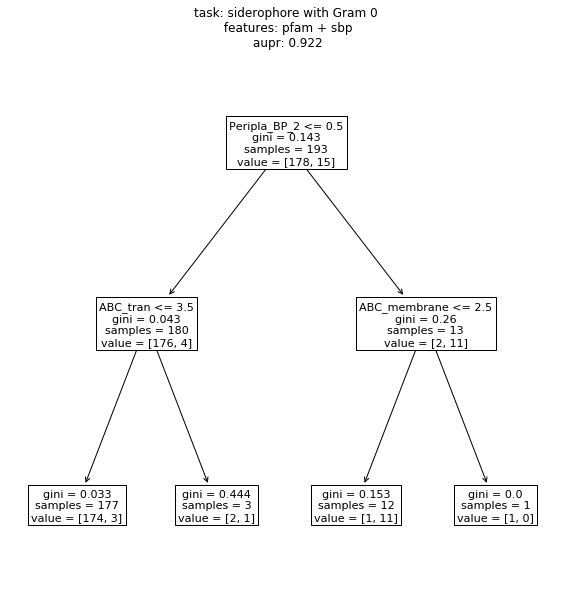

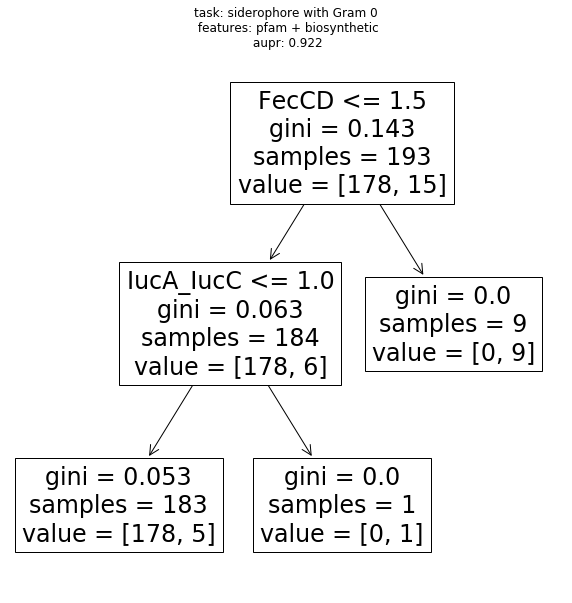

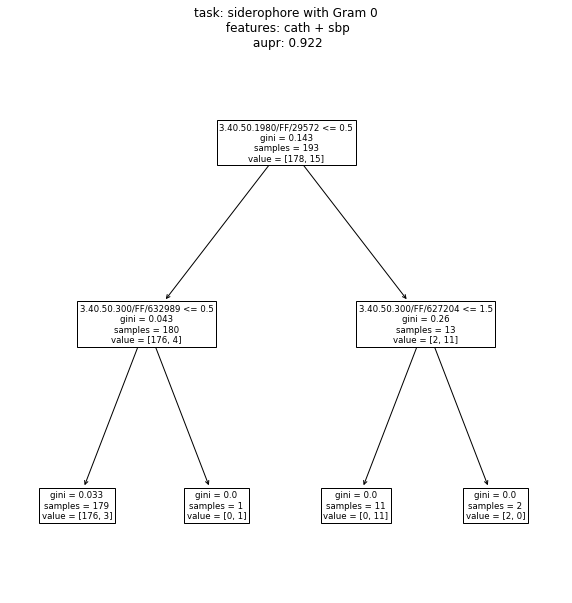

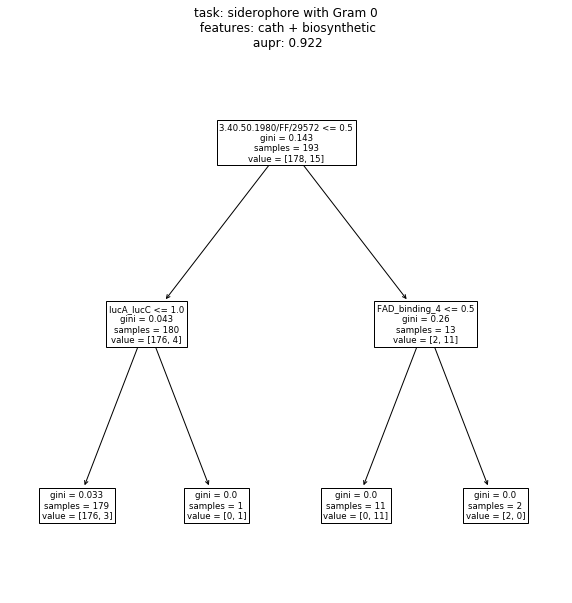

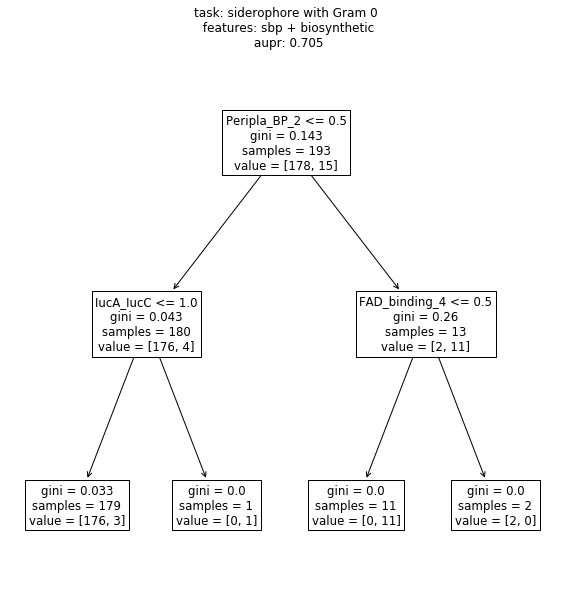

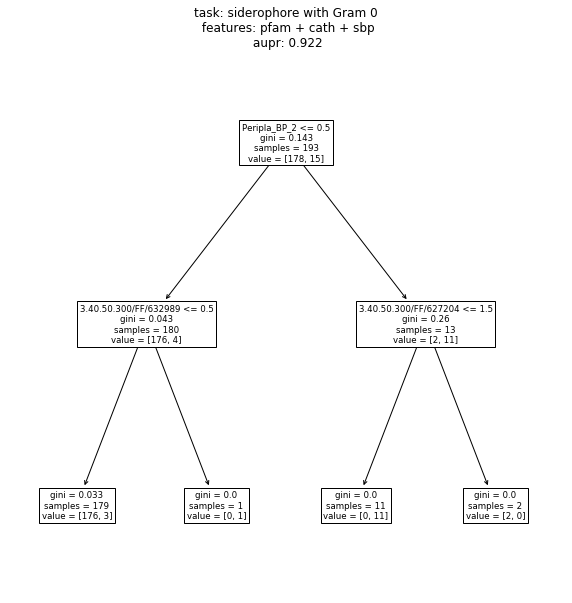

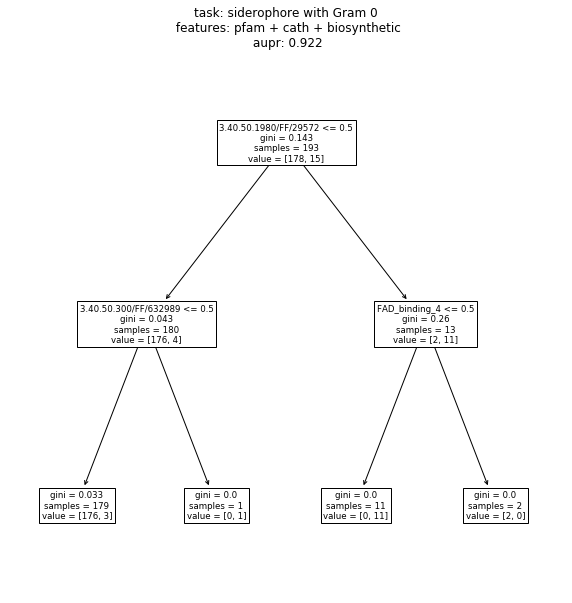

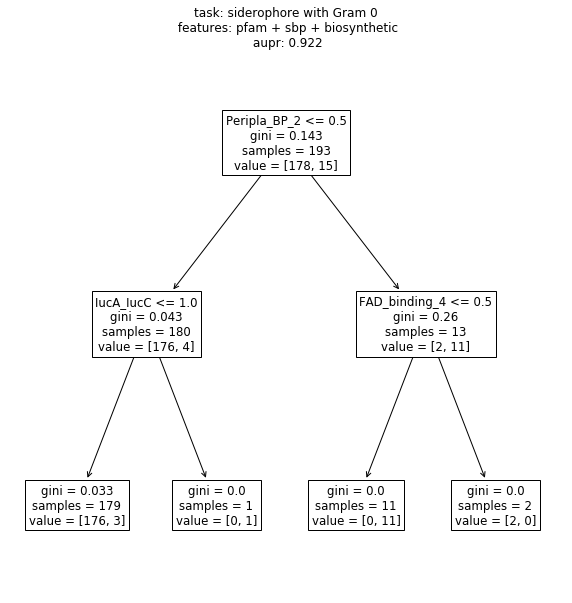

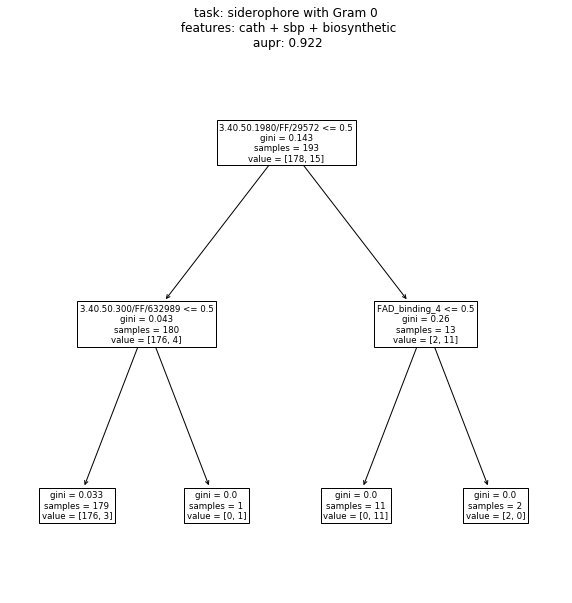

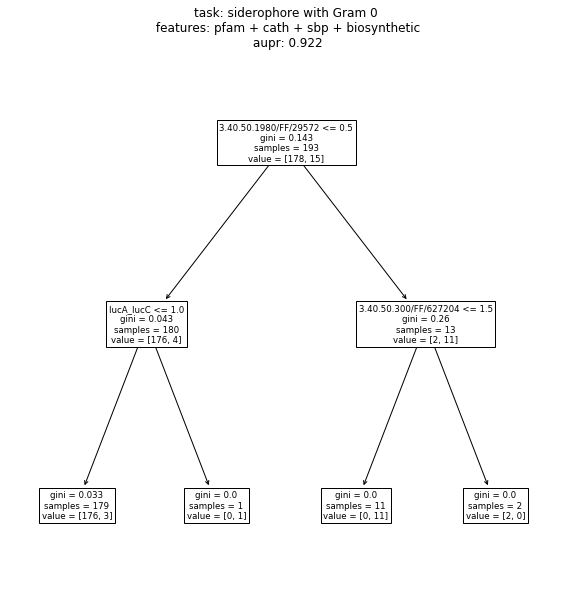

In [14]:
plot_trees(sid_trees, names, sid_auprs, features, 'siderophore')

# Reapplying to MW

Now we will redo it all for molecular weight more compactly.

In [15]:
from prediction_utils import mw_preprocess
mw_data = {k: mw_preprocess(d, meta, verbose=True) for k, d in datasets.items()}

There are 558 examples for binned weight prediction.
Num > 1000: 149
Num <= 1000: 409
There are 558 examples for binned weight prediction.
Num > 1000: 149
Num <= 1000: 409
There are 558 examples for binned weight prediction.
Num > 1000: 149
Num <= 1000: 409
There are 558 examples for binned weight prediction.
Num > 1000: 149
Num <= 1000: 409


In [16]:
mw_pr, mw_rec, mw_auprs, mw_trees, names, features = fit_all_subsets(mw_data)

In [17]:
mw_df = print_aupr(mw_auprs, names)

,G+,G-
Protein Families,,
pfam,0.523829,0.523685
cath,0.565692,0.572307
sbp,0.289657,0.237705
biosynthetic,0.513001,0.732095
pfam + cath,0.529513,0.572307
pfam + sbp,0.523829,0.523685
pfam + biosynthetic,0.598291,0.732095
cath + sbp,0.565692,0.572307
cath + biosynthetic,0.638095,0.753960


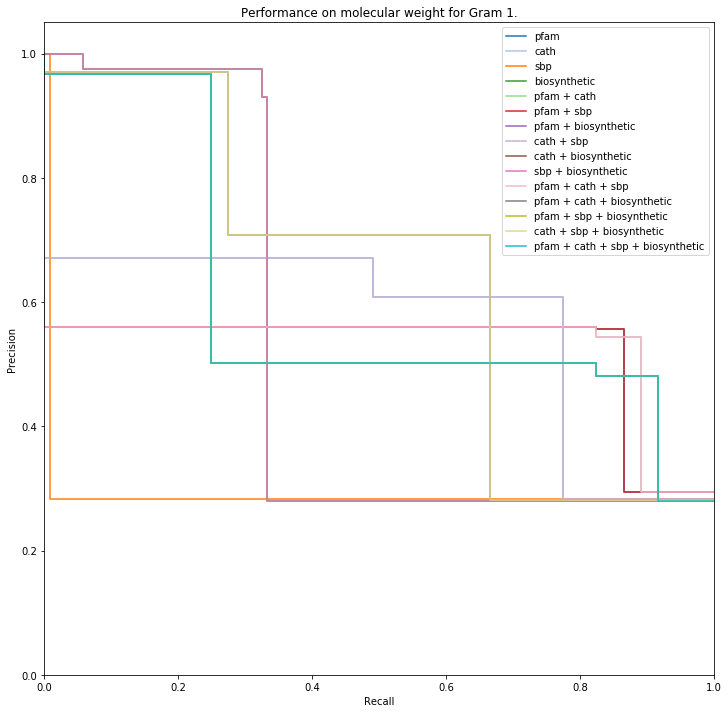

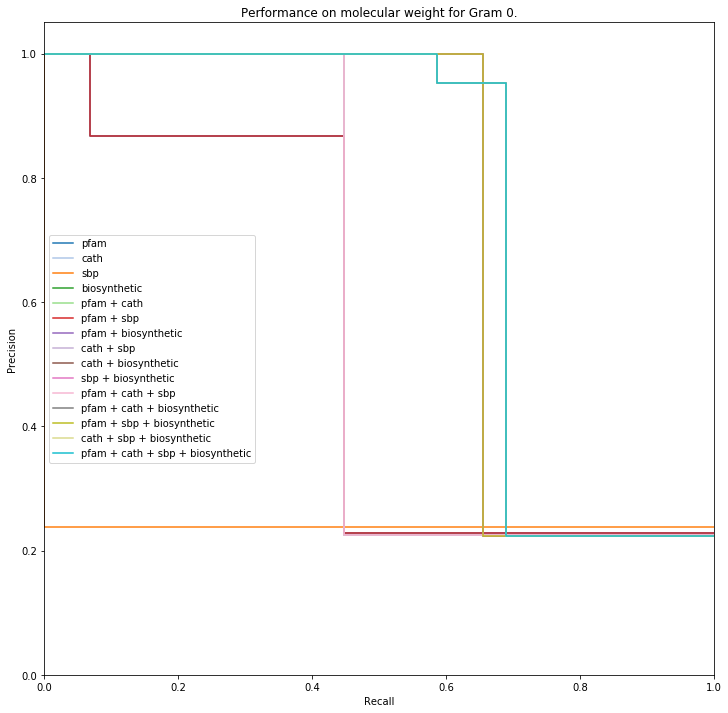

In [18]:
plot_pr_curves(mw_pr, mw_rec, names, 'molecular weight', 'tab20')

Trees for MW, Gram: 1


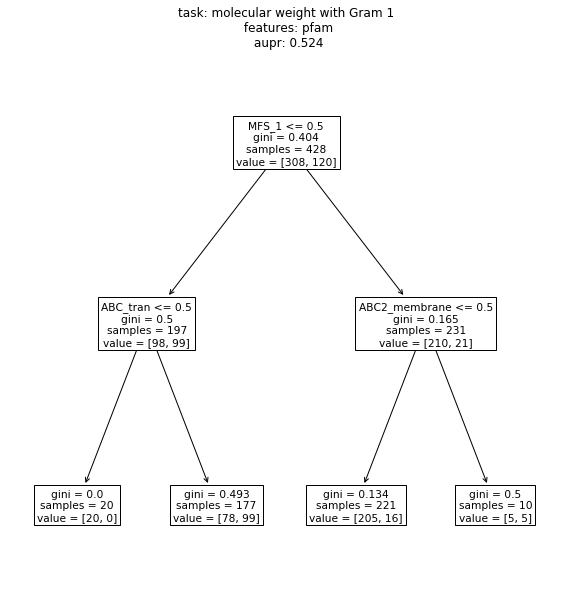

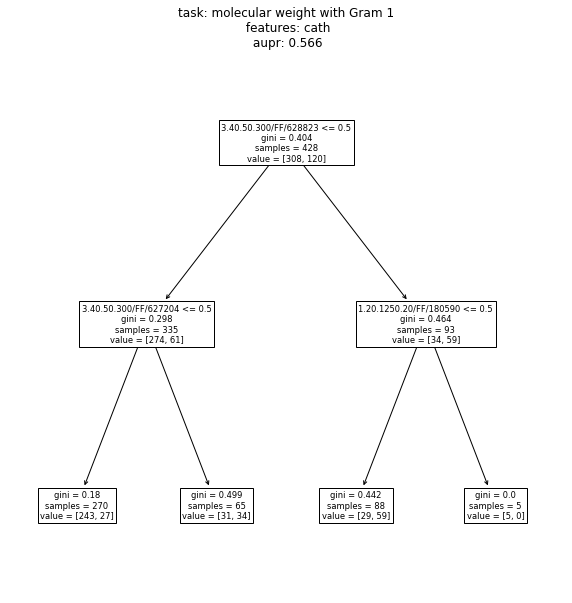

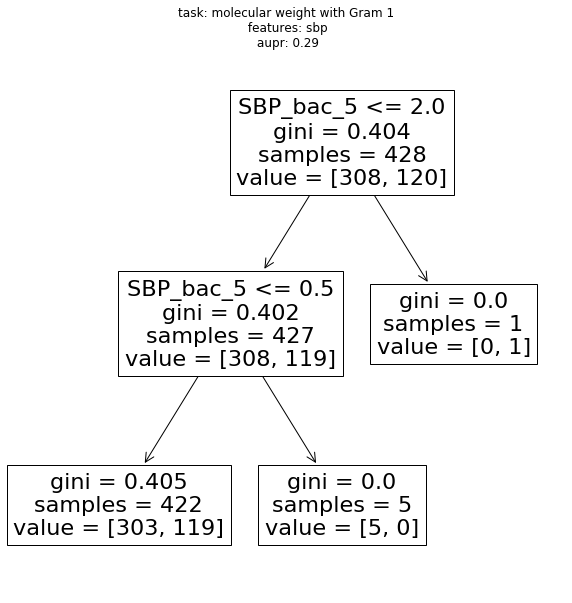

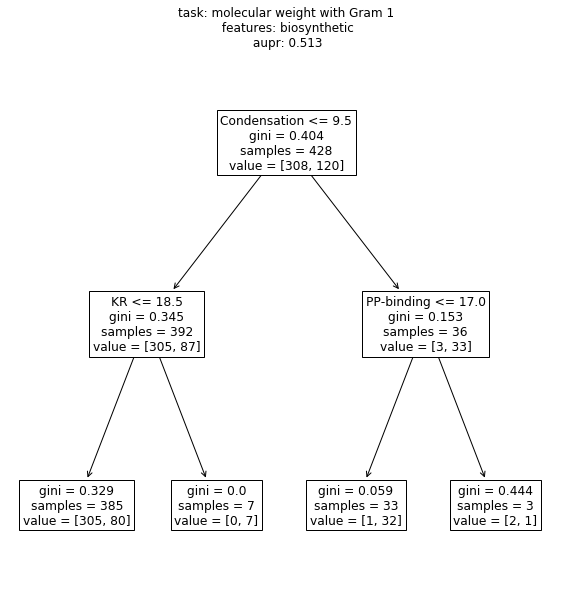

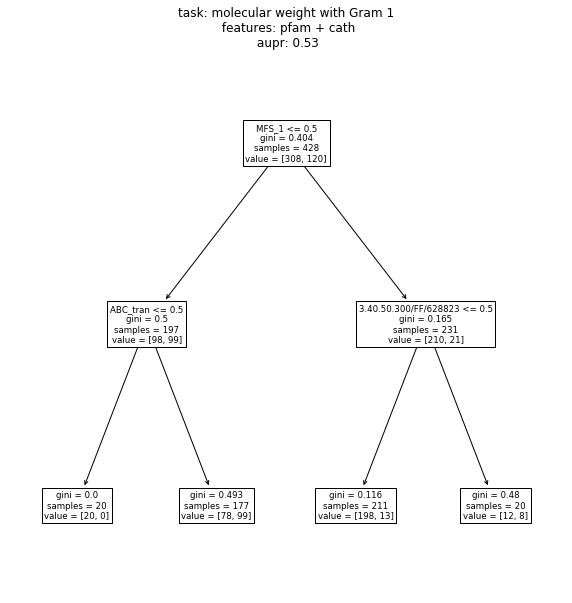

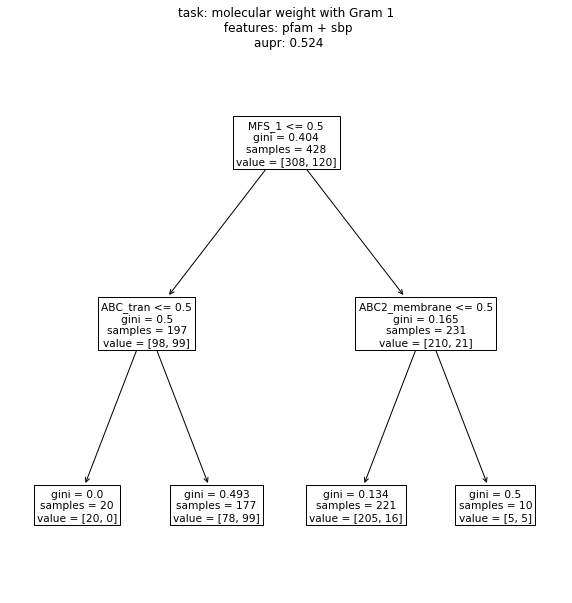

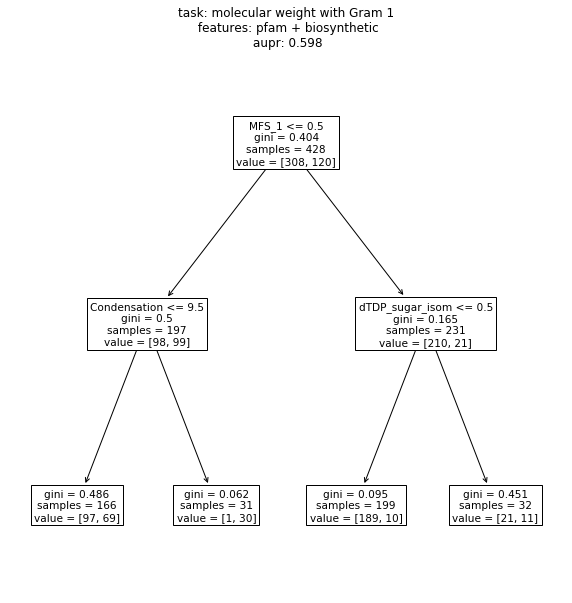

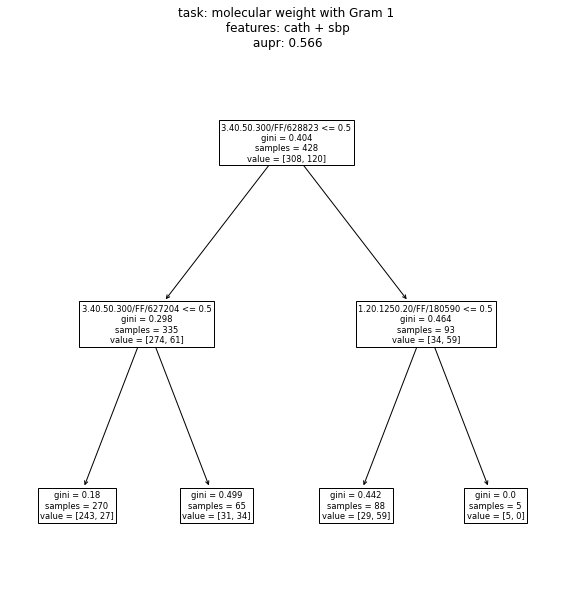

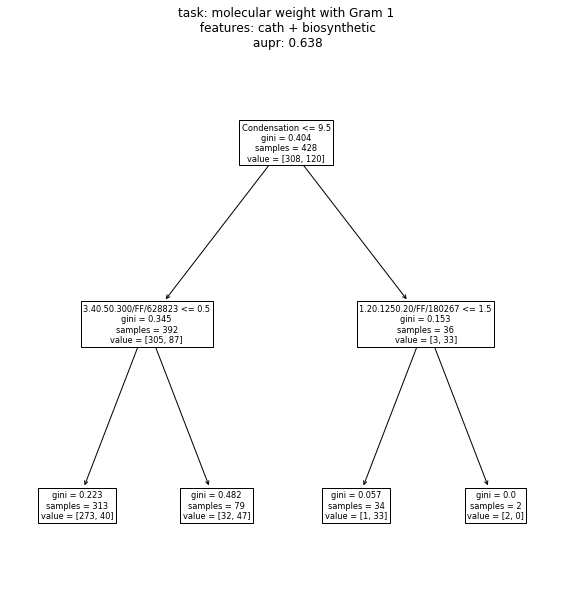

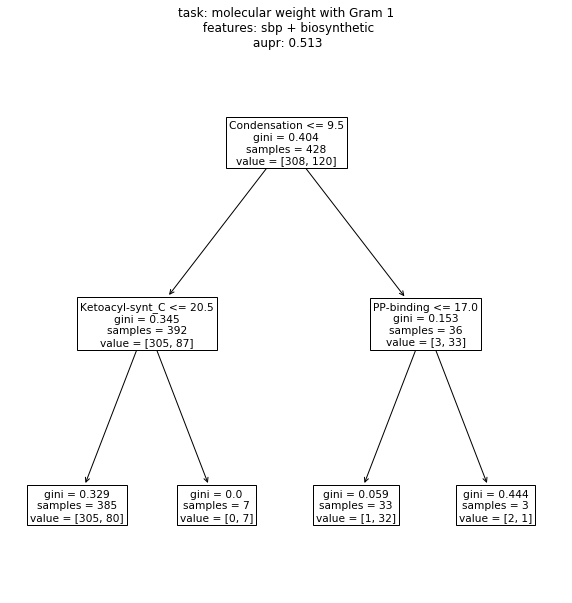

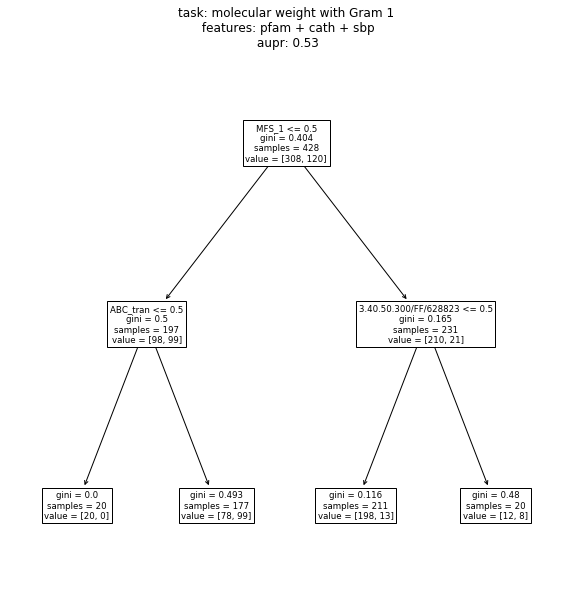

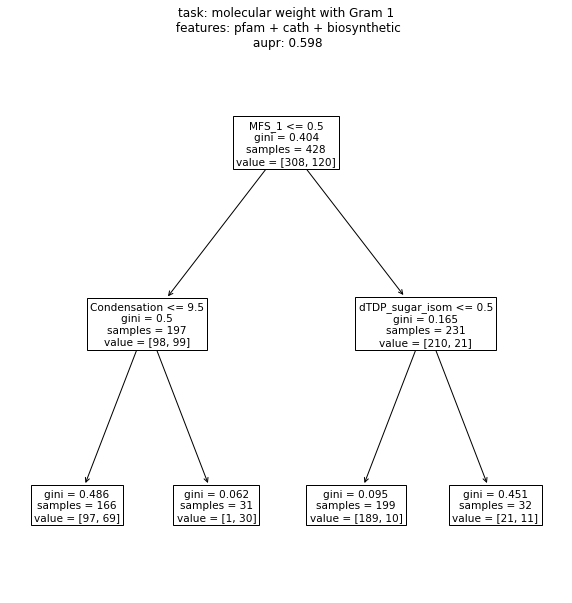

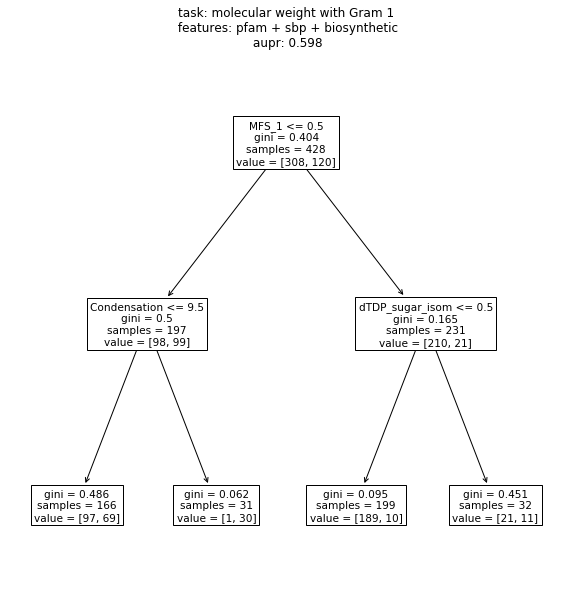

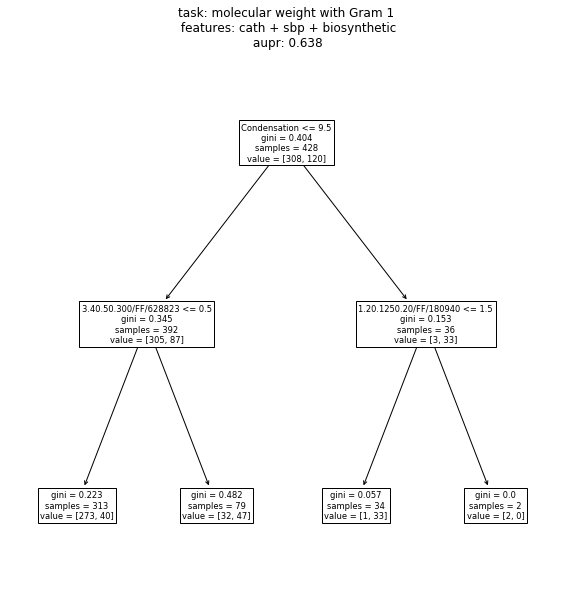

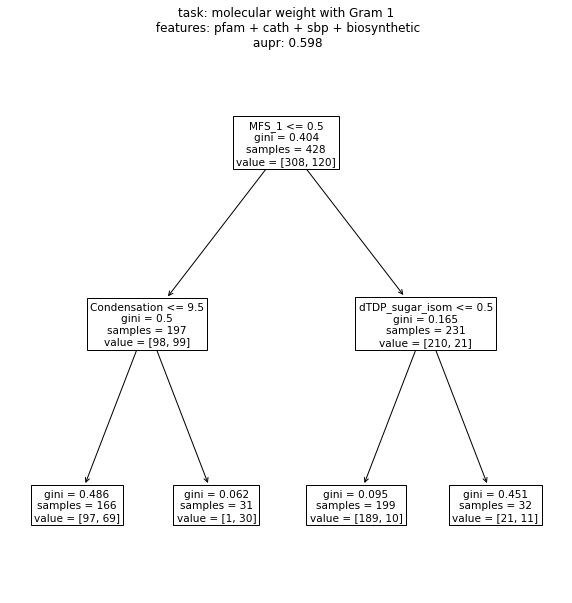

Trees for MW, Gram: 0


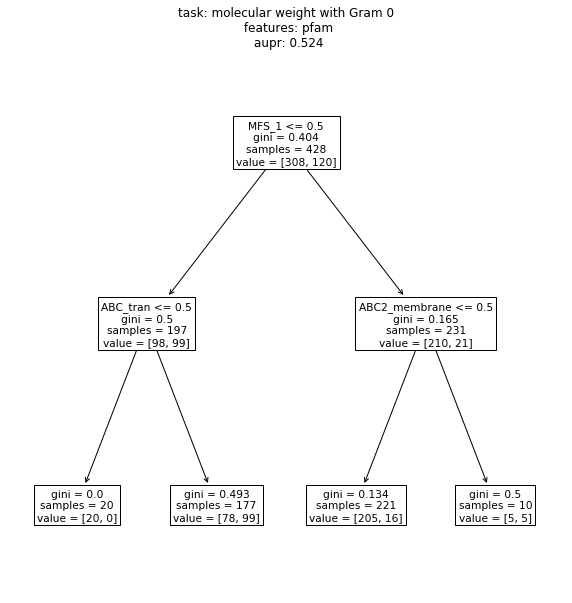

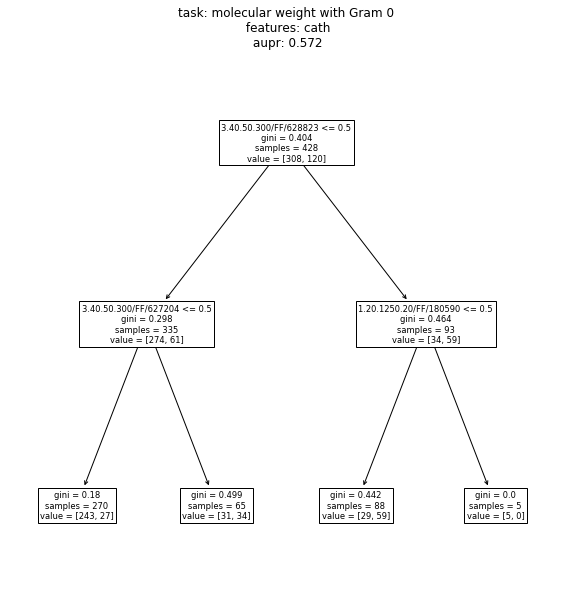

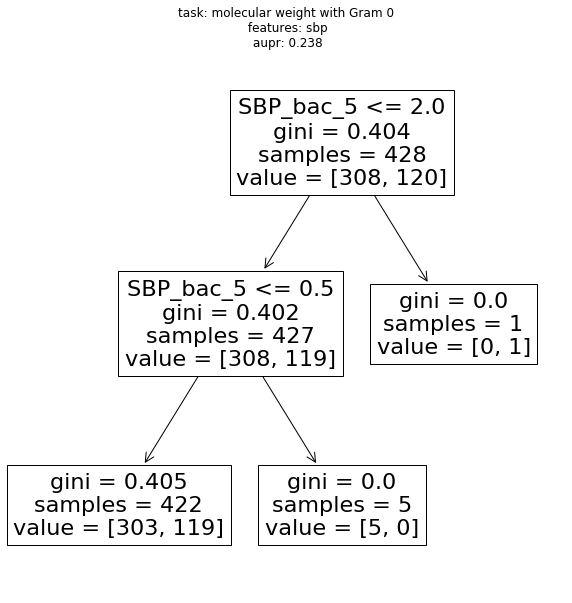

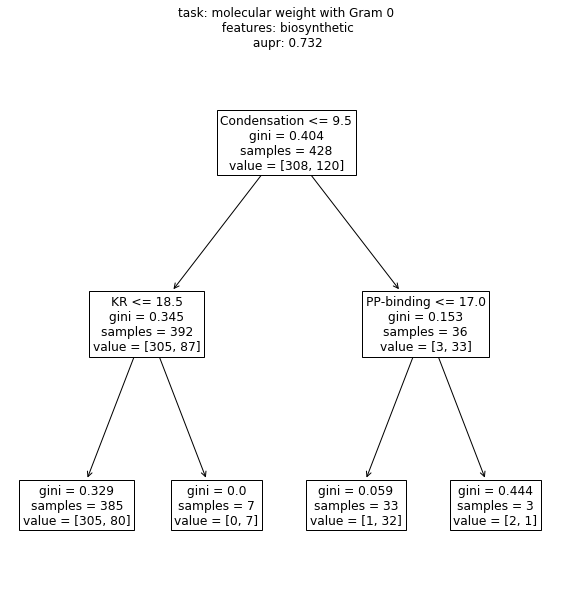

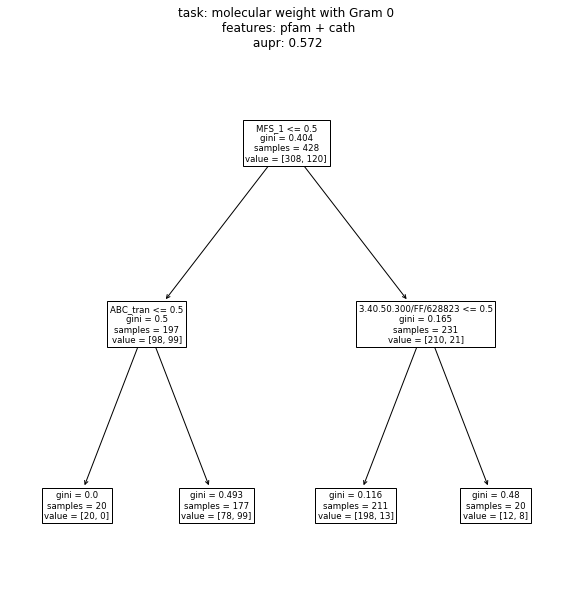

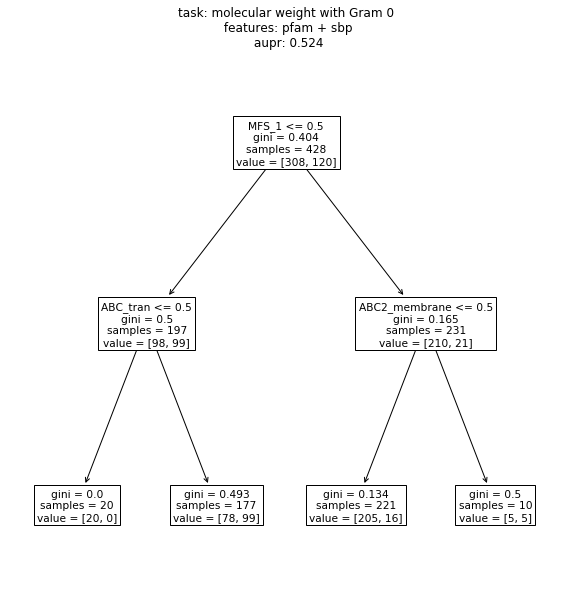

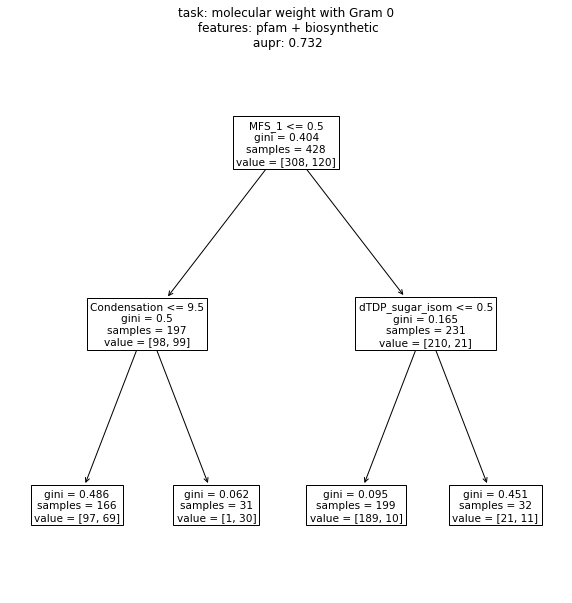

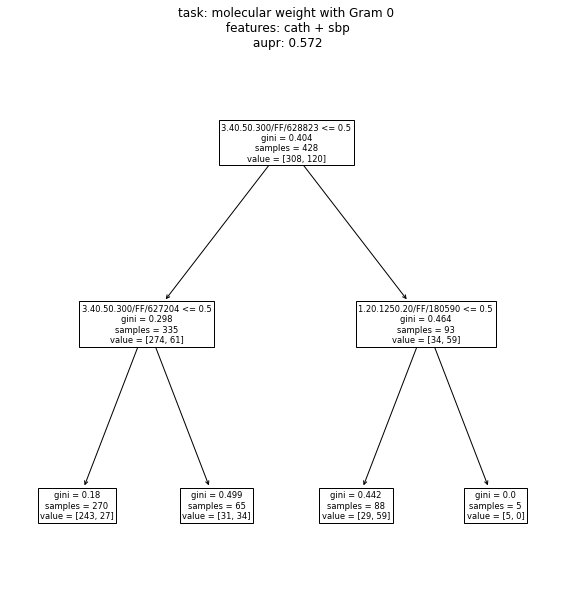

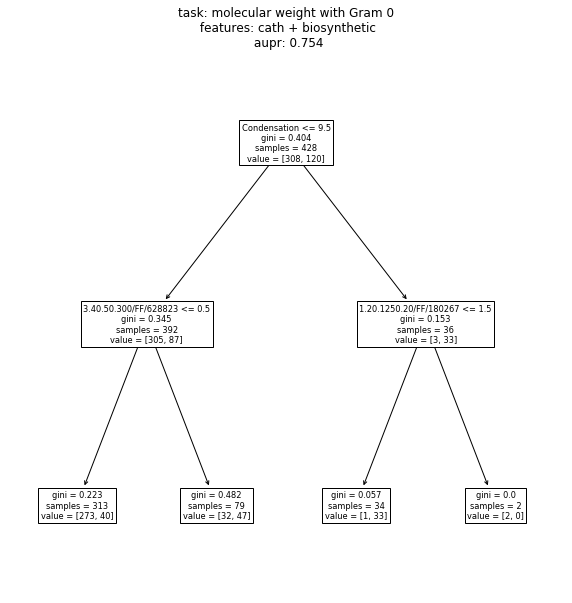

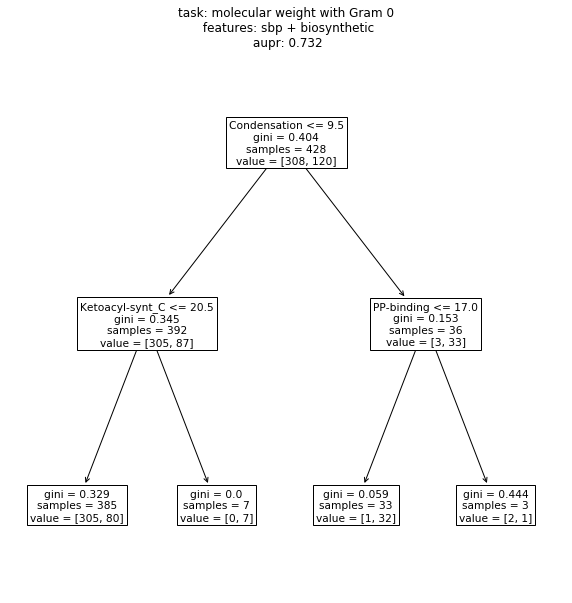

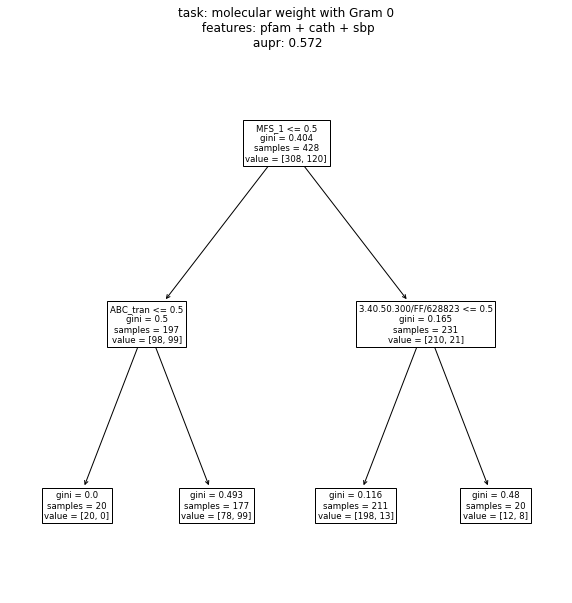

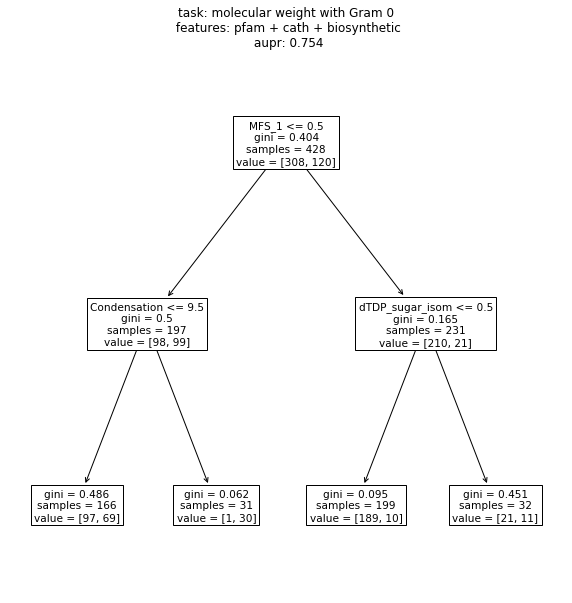

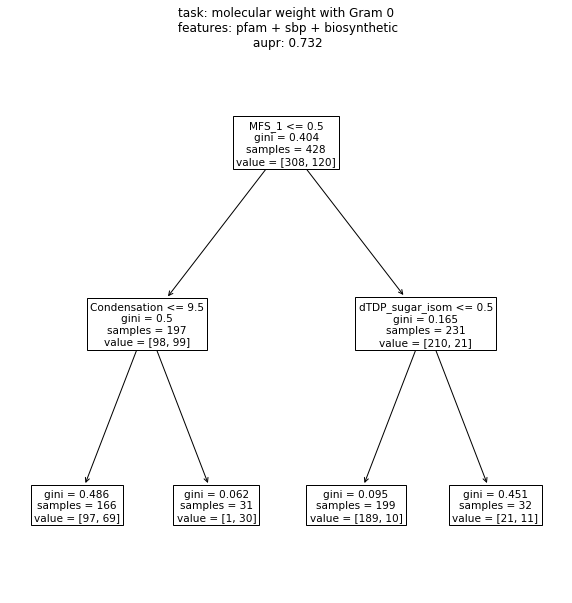

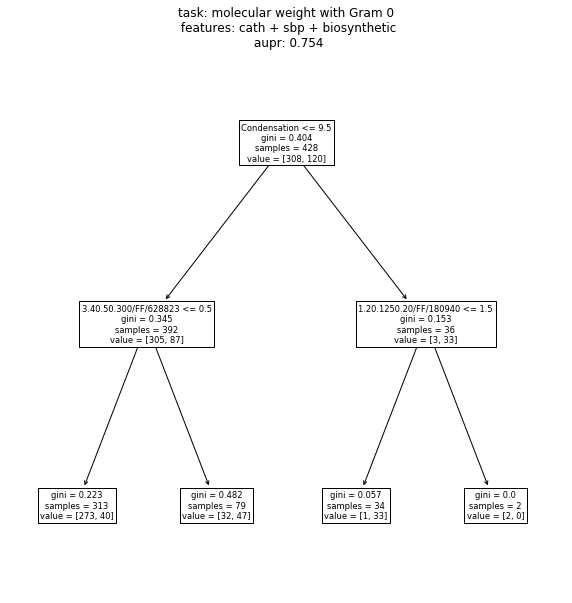

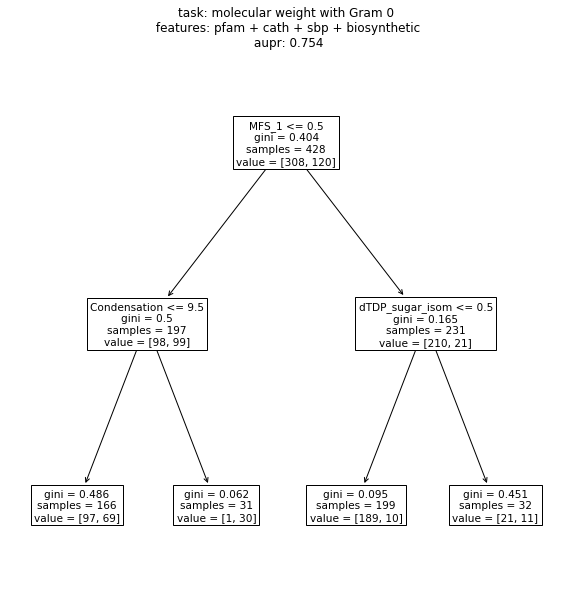

In [19]:
plot_trees(mw_trees, names, mw_auprs, features, 'molecular weight')